In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split
from eigenface_project import eigenface_project
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from time import time, sleep

In [2]:
# Directory paths
train_dir = os.path.expanduser('../raw_data/fer2013/train')
test_dir = os.path.expanduser('../raw_data/fer2013/test')

# Define a function to load the balanced data
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(label)
    return images, labels

# Load training and testing images
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)


print(f"Loaded {len(train_images)} training images.")
print(f"Loaded {len(test_images)} training images.")

Loaded 28709 training images.
Loaded 7178 training images.


In [3]:
# Check the train and test data
print({x: train_labels.count(x) for x in set(train_labels)})
print(np.array(train_images).shape)

print({x: test_labels.count(x) for x in set(test_labels)})
print(np.array(test_images).shape)

{'surprise': 3171, 'sad': 4830, 'angry': 3995, 'happy': 7215, 'neutral': 4965, 'fear': 4097, 'disgust': 436}
(28709, 48, 48)
{'surprise': 831, 'sad': 1247, 'angry': 958, 'happy': 1774, 'neutral': 1233, 'fear': 1024, 'disgust': 111}
(7178, 48, 48)


In [4]:
# set up X, y of train and test
train_Class = np.array(train_labels)
train_images = np.array(train_images)

test_Class = np.array(test_labels)
test_images = np.array(test_images)

In [5]:
# project the image data on the eigen vectors
train_images_project, selected_eigenvectors=eigenface_project(train_images)

test_images_centered = test_images - np.mean(test_images, axis=0)
test_images_project = np.dot(test_images_centered.reshape(test_images.shape[0], -1), selected_eigenvectors)

In [7]:
# define a random forest function, and search the best parameters

def auto_random_forest(
    X,
    y,
    n_estimators=100,
    cv=10,
    random_state=2024
):
    """
    Implement Random Forest with different max_features settings and find optimal value
    
    Parameters:
    X, y: pandas DataFrame containing features and target
    test_size: proportion of data to use for testing in CV
    random_state: random state for reproducibility
    n_estimators: number of trees in forest
    cv: number of cross-validation folds
    """
    
    # number of features
    n_features = np.array(X).shape[1]
    
    # Create different max_features values to try
    # Include common options and some specific numbers
    max_features_options = [
        "log2",
        "sqrt",
        0.1,     # 10% of features
        0.2,     # 20% of features
    ]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create parameter grid
    param_grid = {
        'max_features': max_features_options,
        'min_samples_split': [2, 5, 10, 20, 30, 40, 50],
        # 'min_samples_leaf': [2, 5, 10, 20, 30, 40, 50]
        'max_depth': [3, 5, 7, 10, 20, 30]
    }
    
    # Initialize Random Forest
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        max_samples=0.3,
        bootstrap=True
    )
    
    # 3. Setup StratifiedKFold
    skf = StratifiedKFold(
        n_splits=cv,
        shuffle=True,
        random_state=random_state
    )
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1, # use all the CPU cores
        verbose=2  # detailed output monitoring progress updates
    )
    
    # Fit grid search
    grid_search.fit(X_scaled, y)
    
    # Get best model, best params, and best score
    best_rf = grid_search.best_estimator_
    best_par = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Compile results
    results = {
        'best_params': best_par,
        'best_score': best_score,
        'best_model': best_rf
    }
    
    return results

In [8]:
start_time = time()

# Grid search the best model
random_forest_result = auto_random_forest(X=train_images_project, y=train_Class)

end_time = time()
print(f"Runtime: {(end_time - start_time)/60} mins")

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Runtime: 8.067814755439759 mins


In [9]:
# loop through and print the results
for key, value in random_forest_result.items():
    print(f"{key}: \n {value}")

best_params: 
 {'max_depth': 30, 'max_features': 0.2, 'min_samples_split': 2}
best_score: 
 0.40398432237793047
best_model: 
 RandomForestClassifier(max_depth=30, max_features=0.2, max_samples=0.3,
                       random_state=2024)


In [6]:
# work on the test data set
# fit with the best model with 1000 trees
scaler = StandardScaler()
scaler.fit(train_images_project)
train_images_scaled = scaler.transform(train_images_project)
test_images_scaled = scaler.transform(test_images_project)
rf = RandomForestClassifier(max_depth=30, max_features=0.2, min_samples_split=2,
                       random_state=2024, max_samples=0.5, n_estimators=2000, bootstrap=True, n_jobs=20)
rf.fit(train_images_scaled, train_Class)
test_Class_pred = rf.predict(test_images_scaled)
train_Class_pred = rf.predict(train_images_scaled)

In [16]:
# feature importance
rf.feature_importances_

array([0.01823623, 0.01181555, 0.01060743, 0.01214427, 0.00969732,
       0.00909857, 0.00906644, 0.01123851, 0.01220869, 0.01111915,
       0.00890865, 0.01204467, 0.00908749, 0.02040163, 0.01334773,
       0.00943877, 0.01087122, 0.00968903, 0.00921292, 0.01004377,
       0.00934425, 0.01125186, 0.02111256, 0.00915379, 0.00899485,
       0.00933492, 0.01039433, 0.00982238, 0.00926783, 0.01168326,
       0.00901563, 0.0092329 , 0.01056328, 0.00907241, 0.00945345,
       0.01110538, 0.00942215, 0.00867061, 0.00889935, 0.00981794,
       0.00940656, 0.00895653, 0.00913457, 0.00883522, 0.00873579,
       0.00894899, 0.00913958, 0.00892837, 0.01033469, 0.01079827,
       0.01033302, 0.00994366, 0.00878894, 0.00879105, 0.00893271,
       0.00871748, 0.00926743, 0.00873415, 0.00881128, 0.00878103,
       0.00928765, 0.00885792, 0.00901284, 0.00909715, 0.00952219,
       0.00880631, 0.0097015 , 0.00886796, 0.00886916, 0.00883299,
       0.00872399, 0.00890131, 0.00877499, 0.00876085, 0.00887

In [17]:
# train accuracy
print(accuracy_score(train_Class, train_Class_pred))
        
# classification_report
print(classification_report(train_Class, train_Class_pred))

0.9984325472848236
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      3995
     disgust       1.00      1.00      1.00       436
        fear       1.00      1.00      1.00      4097
       happy       1.00      1.00      1.00      7215
     neutral       1.00      1.00      1.00      4965
         sad       1.00      1.00      1.00      4830
    surprise       1.00      1.00      1.00      3171

    accuracy                           1.00     28709
   macro avg       1.00      1.00      1.00     28709
weighted avg       1.00      1.00      1.00     28709



In [18]:
# test accuracy
print(accuracy_score(test_Class, test_Class_pred))
        
# classification_report
print(classification_report(test_Class, test_Class_pred))

0.4453886876567289
              precision    recall  f1-score   support

       angry       0.81      0.14      0.24       958
     disgust       1.00      0.30      0.46       111
        fear       0.58      0.23      0.33      1024
       happy       0.38      0.86      0.53      1774
     neutral       0.45      0.31      0.37      1233
         sad       0.40      0.32      0.35      1247
    surprise       0.67      0.59      0.63       831

    accuracy                           0.45      7178
   macro avg       0.61      0.39      0.41      7178
weighted avg       0.53      0.45      0.41      7178



In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [12]:
# comfusion matrix 
cm = confusion_matrix(test_Class, test_Class_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

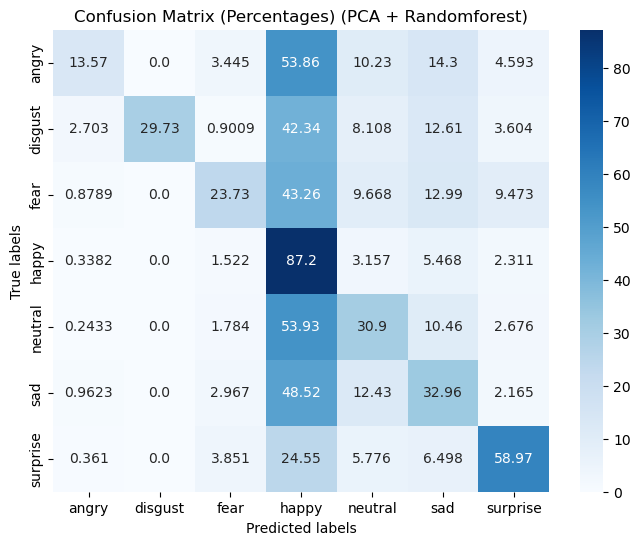

In [13]:
# Create the heatmap with annotations as percentages
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized*100, annot=True, fmt='.4', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)  # Format as percentages with 2 decimal places
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Percentages) (PCA + Randomforest)')
plt.show()